In [94]:
import sys, time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('white')
palette = 'magma_r'
%matplotlib inline

# Helmholtz equation

The Helmholtz equation is the eigenvalue problem for the Laplace operator. Recall the definition of the Laplace operator in 2D:

$$
\begin{align}
\nabla^2 u &= \frac{\delta^2 u}{\delta x^2} + \frac{\delta^2 u}{\delta y^2}
\end{align}
$$

And recall the definition of eigenvalues $\lambda$ and eigenvectors $\vec{v}$ for a linear transformation $A$:

$$
\begin{align}
A \vec{v} &= \lambda \vec{v}
\end{align}
$$

The Helmholtz equation defines an implicit function $u(x,y)$ that is an *eigenfunction* of the Laplace operator for the eigenvalue $-k^2$. Intuitively, $u$ is a function such that repeatedly applying the Laplace operator only scales the function by $-k^2$.

$$
\begin{align}
\nabla^2 u &= -k^2 u \\
\frac{\delta^2 u}{\delta x^2} + \frac{\delta^2 u}{\delta y^2} &= -k^2 u
\end{align}
$$

Note that, similar to the Laplace and Poisson equations, the Helmholtz equation is time-independent. It describes equilibrium states of a system.

Let's discretize the Helmholtz equation using finite differences.

$$
\begin{align}
\frac{u(x + \Delta x,y) - 2 u(x,y) + u(x - \Delta x,y)}{\Delta x^2} + \frac{u(x,y + \Delta y) - 2 u(x,y) + u(x,y - \Delta y)}{\Delta y^2} &= -k^2 u(x,y) \\
[u(x + \Delta x,y) - 2 u(x,y) + u(x - \Delta x,y)] \Delta y^2 + [u(x,y + \Delta y) - 2 u(x,y) + u(x,y - \Delta y) ] \Delta x^2  &= -k^2 u(x,y) \Delta x^2 \Delta y^2 \\
[u(x + \Delta x,y) + u(x - \Delta x,y)] \Delta y^2 + [u(x,y + \Delta y) + u(x,y - \Delta y) ] \Delta x^2  &= u(x,y) (2 \Delta x^2 + 2 \Delta y^2 -k^2 \Delta x^2 \Delta y^2) \\
\frac{[u(x + \Delta x,y) + u(x - \Delta x,y)] \Delta y^2 + [u(x,y + \Delta y) + u(x,y - \Delta y) ] \Delta x^2}{2 \Delta x^2 + 2 \Delta y^2 -k^2 \Delta x^2 \Delta y^2}  &= u(x,y)
\end{align}
$$

Then convert to the solver computation.

$$
\begin{align}
u_{n,i,j} &= \frac{[u_{n,i+1,j}  + u_{n,i-1,j}] \Delta y^2 + [u_{n,i,j+1} + u_{n,i,j-1} ] \Delta x^2}{2 \Delta x^2 + 2 \Delta y^2 - k^2 \Delta x^2 \Delta y^2} \\
\end{align}
$$

c:\users\mtr22\code\miniconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
c:\users\mtr22\code\miniconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


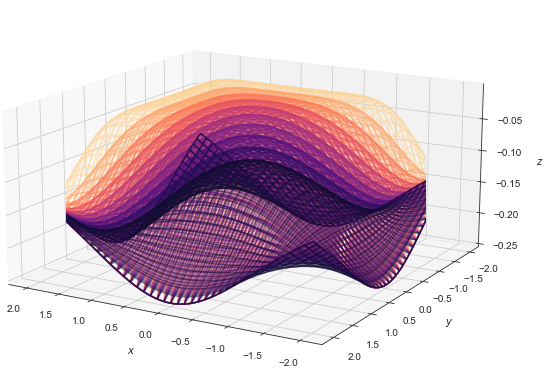

In [104]:
# 2D Helmholtz equation
n_x = 81
n_y = 81
n_t = 1001 # number of iterations

dx = 4 / (n_x - 1)
dy = 4 / (n_y - 1)
# no time resolution

k = -1.0

mod = 100

# color by time step
colors = iter(sns.color_palette(palette, n_t//mod))

# spatial grid points
x = np.linspace(0, (n_x-1)*dx, n_x) - 2
y = np.linspace(0, (n_y-1)*dy, n_y) - 2
X, Y = np.meshgrid(x, y)

# initial/boundary conditions
p = np.zeros((n_t, n_x, n_y))
p[0] = -1/(X**2 + Y**2)
p[0,1:-1,1:-1] = 0

fig = plt.figure(figsize=(15,5))
ax = Axes3D(fig, auto_add_to_figure=False)
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.5, 1.5, 1, 1]))
fig.add_axes(ax)

#surf = ax.plot_wireframe(X, Y, p[0].T, color=next(colors), alpha=1.0)

for n in range(1, n_t):
    
    # reset boundary conditions
    p[n] = -1/(X**2 + Y**2)

    p[n,1:-1,1:-1] = (
        dy**2 * (p[n-1,2:,1:-1] + p[n-1,:-2,1:-1]) +
        dx**2 * (p[n-1,1:-1,2:] + p[n-1,1:-1,:-2])
    ) / (2*(dx**2 + dy**2) - k**2 * dx**2 * dy**2)

    if n%mod == 0:
        surf = ax.plot_wireframe(X, Y, p[n].T, color=next(colors), alpha=0.5)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.view_init(15, 120)